*Importing* liberaries

In [29]:
import torch
from torch import nn
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
import pandas as pd
from scipy.sparse import hstack
import gensim.downloader as api
import numpy as np

Loading pre trained word2vec

In [30]:
import os
import gensim.downloader as api

model_name = 'word2vec-google-news-300'

# Check if the model is already downloaded
try:
    word2vec_model = api.load(model_name)
    print("Loaded the existing model.")
except KeyError:
    # If model is not found, it will download
    word2vec_model = api.load(model_name)
    print("Model was not found locally. Downloading now.")


Loaded the existing model.


*Preprocessing* data

In [31]:
# Load the dataset and skip any bad lines
movie_data = pd.read_csv('movie_meta_data.csv', on_bad_lines='skip')

# Fill missing values for text columns with empty strings and for numerical columns with the median
movie_data['plot'] = movie_data['plot'].fillna('')
movie_data['keywords'] = movie_data['keywords'].fillna('')
movie_data['genres'] = movie_data['genres'].fillna('')
movie_data['producers'] = movie_data['producers'].fillna('')
movie_data['directors'] = movie_data['directors'].fillna('')
movie_data['casting directors'] = movie_data['casting directors'].fillna('')
movie_data['taglines'] = movie_data['taglines'].fillna('')
movie_data['countries'] = movie_data['countries'].fillna('')
movie_data['year'] = movie_data['year'].fillna(movie_data['year'].median())

Exploratory Data Analytics

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Basic statistics for numerical features
numerical_columns = ['year', 'metascore', 'imdb user rating', 'number of imdb user votes']
summary_stats = movie_data[numerical_columns].describe()
print(summary_stats)

              year    metascore  imdb user rating  number of imdb user votes
count  2858.000000  2858.000000       2858.000000               2.858000e+03
mean   1986.665150    44.815605          5.856543               1.392193e+05
std     154.879642    32.738149          2.190857               2.283760e+05
min      -1.000000    -1.000000         -1.000000              -1.000000e+00
25%    1992.000000    -1.000000          6.000000               7.400000e+03
50%    2003.000000    54.000000          6.000000               5.436900e+04
75%    2011.000000    71.000000          7.000000               1.689790e+05
max    2021.000000   100.000000          9.000000               2.312225e+06


Correlation heatmap


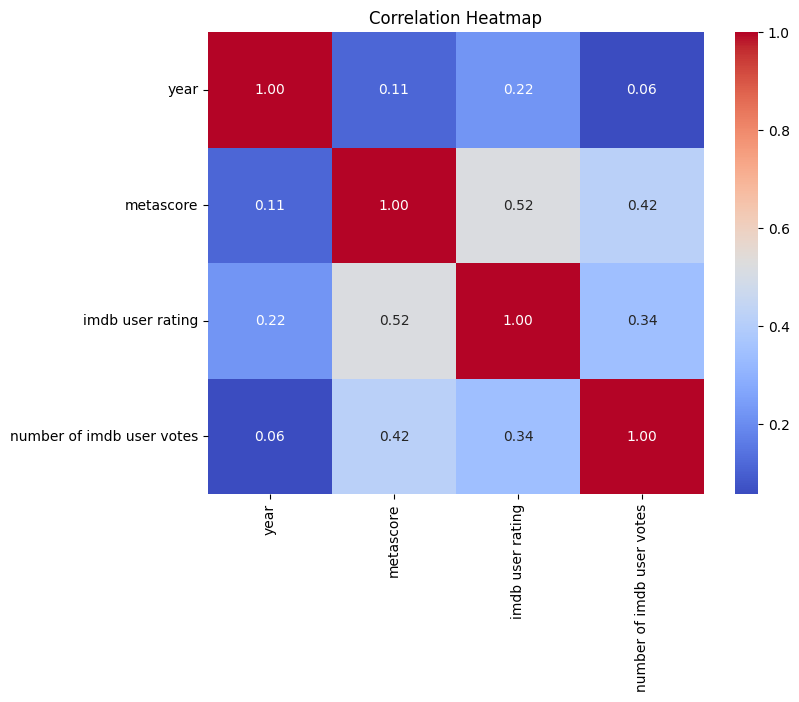

In [33]:
correlation_matrix = movie_data[numerical_columns].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Correlation Heatmap')
plt.show()

Distribution of genres (this is a sample for categorical columns)


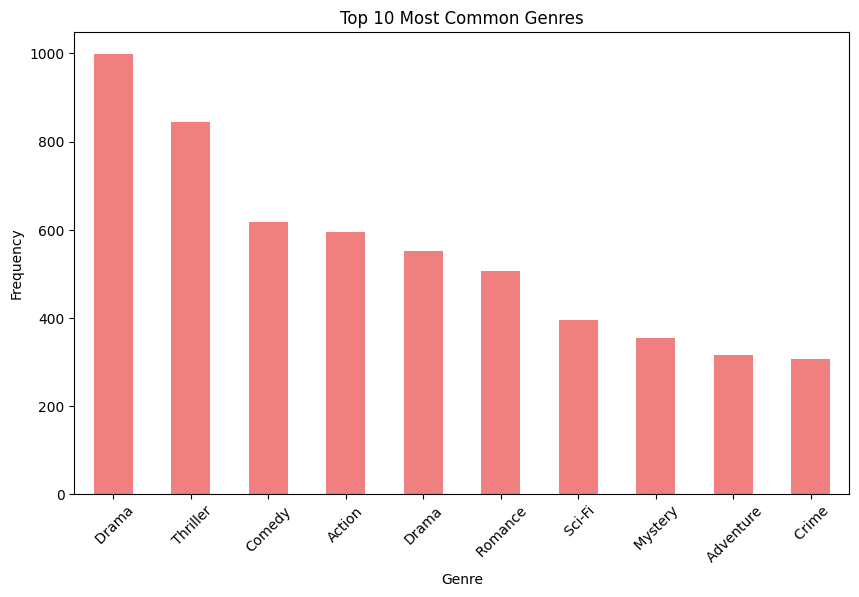

In [34]:
# Let's plot the top 10 most common genres
top_genres = movie_data['genres'].str.split(',', expand=True).stack().value_counts().head(10)
plt.figure(figsize=(10, 6))
top_genres.plot(kind='bar', color='lightcoral')
plt.title('Top 10 Most Common Genres')
plt.xlabel('Genre')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

Using linear regression as a base model

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
file_path = 'movie_meta_data.csv'
movie_data_lr = pd.read_csv(file_path)

movie_data_lr = movie_data_lr.dropna(subset=['plot', 'genres', 'directors', 'casting directors', 'keywords', 'imdb user rating'])

In [54]:

X = movie_data_lr[['plot', 'genres', 'directors', 'casting directors', 'keywords']]
y = movie_data_lr['imdb user rating']

tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=500)
X_plot = tfidf_vectorizer.fit_transform(X['plot']).toarray()
X_keywords = tfidf_vectorizer.fit_transform(X['keywords']).toarray()

label_encoder = LabelEncoder()

X_genre = X['genres'].str.split(',').apply(lambda x: ', '.join(x)).values
X_genre_encoded = label_encoder.fit_transform(X_genre)

X_directors = label_encoder.fit_transform(X['directors'])
X_casting_directors = label_encoder.fit_transform(X['casting directors'])

X_combined = np.hstack([X_plot, X_keywords, X_genre_encoded.reshape(-1, 1), X_directors.reshape(-1, 1), X_casting_directors.reshape(-1, 1)])

X_train, X_temp, y_train, y_temp = train_test_split(X_combined, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)


In [55]:
model = torch.nn.Linear(X_train.shape[1], 1)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 300
train_losses = []
val_losses = []
train_mer = []
val_mer = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    y_train_pred = model(X_train_tensor)
    train_loss = criterion(y_train_pred, y_train_tensor)
    train_loss.backward()
    optimizer.step()

    train_abs_error = torch.abs(y_train_pred - y_train_tensor)
    train_med_er = torch.median(train_abs_error)

    model.eval()
    with torch.no_grad():
        y_val_pred = model(X_val_tensor)
        val_loss = criterion(y_val_pred, y_val_tensor)

        val_abs_error = torch.abs(y_val_pred - y_val_tensor)
        val_med_er = torch.median(val_abs_error)

    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())
    train_mer.append(train_med_er.item())
    val_mer.append(val_med_er.item())

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Train MedER: {train_med_er.item():.4f}, "
          f"Validation Loss: {val_loss.item():.4f}, Validation MedER: {val_med_er.item():.4f}")

Epoch [1/300], Train Loss: 1572.8600, Train MedER: 38.1864, Validation Loss: 1423.0009, Validation MedER: 36.0977
Epoch [2/300], Train Loss: 1460.0767, Train MedER: 36.8452, Validation Loss: 1317.3538, Validation MedER: 34.7466
Epoch [3/300], Train Loss: 1351.6420, Train MedER: 35.4402, Validation Loss: 1216.0125, Validation MedER: 33.3298
Epoch [4/300], Train Loss: 1247.6263, Train MedER: 34.1067, Validation Loss: 1119.0365, Validation MedER: 32.0536
Epoch [5/300], Train Loss: 1148.0907, Train MedER: 32.7256, Validation Loss: 1026.4753, Validation MedER: 30.7053
Epoch [6/300], Train Loss: 1053.0858, Train MedER: 31.3147, Validation Loss: 938.3674, Validation MedER: 29.1821
Epoch [7/300], Train Loss: 962.6509, Train MedER: 29.8950, Validation Loss: 854.7396, Validation MedER: 27.8059
Epoch [8/300], Train Loss: 876.8138, Train MedER: 28.6314, Validation Loss: 775.6062, Validation MedER: 26.3037
Epoch [9/300], Train Loss: 795.5892, Train MedER: 27.2304, Validation Loss: 700.9685, Validat

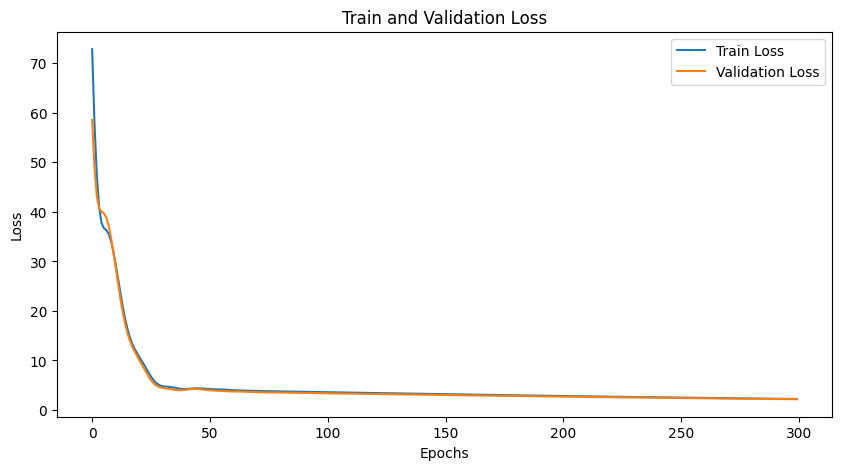

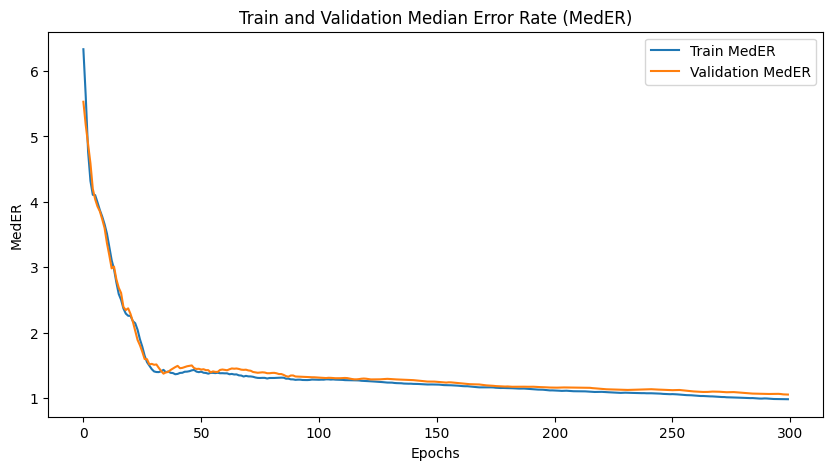

In [52]:
# Plot the losses and MedER for both training and validation
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# Plot Median Error Rate (MedER)
plt.figure(figsize=(10, 5))
plt.plot(train_mer, label='Train MedER')
plt.plot(val_mer, label='Validation MedER')
plt.xlabel('Epochs')
plt.ylabel('MedER')
plt.title('Train and Validation Median Error Rate (MedER)')
plt.legend()
plt.show()

Function to compute the average Word2Vec embedding for a text (list of words)

In [35]:
def get_average_word2vec(text, model, num_features=300):
    words = text.split()
    word_vecs = []
    for word in words:
        if word in model.key_to_index:
            word_vecs.append(model[word])
    if len(word_vecs) == 0:
        return np.zeros(num_features)
    return np.mean(word_vecs, axis=0)

Initialize the preprocessors

In [36]:
mlb = MultiLabelBinarizer()
scaler = StandardScaler()

# Fit MultiLabelBinarizer for genres and StandardScaler for year, budget, and runtime
mlb.fit(movie_data['genres'].str.split(','))
scaler.fit(movie_data[['year']])

StandardScaler()

Function to compute the average Word2Vec embedding for a text (list of words)

In [37]:
def get_average_word2vec(text, model, num_features=300):
    words = text.split()
    word_vecs = []
    for word in words:
        if word in model.key_to_index:
            word_vecs.append(model[word])
    if len(word_vecs) == 0:
        return np.zeros(num_features)
    return np.mean(word_vecs, axis=0)

# Process features using Word2Vec

In [38]:

X_plot_vecs = np.array([get_average_word2vec(plot, word2vec_model) for plot in movie_data['plot']])
X_keywords_vecs = np.array([get_average_word2vec(keywords, word2vec_model) for keywords in movie_data['keywords']])
X_producers_vecs = np.array([get_average_word2vec(producers, word2vec_model) for producers in movie_data['producers']])
X_directors_vecs = np.array([get_average_word2vec(directors, word2vec_model) for directors in movie_data['directors']])
X_casting_directors_vecs = np.array([get_average_word2vec(casting_directors, word2vec_model) for casting_directors in movie_data['casting directors']])
X_taglines_vecs = np.array([get_average_word2vec(taglines, word2vec_model) for taglines in movie_data['taglines']])

# Process genres and year columns
X_genres = mlb.transform(movie_data['genres'].str.split(','))
X_year = scaler.transform(movie_data[['year']].values)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


# Combine all features into a single feature matrix

In [39]:

X_combined = np.hstack([
    X_plot_vecs, X_keywords_vecs, X_producers_vecs, X_directors_vecs, X_genres,
    X_casting_directors_vecs, X_taglines_vecs, X_year
])

# Convert to PyTorch tensor
X_tensor = torch.tensor(X_combined, dtype=torch.float32)

In [40]:
ratings = movie_data['imdb user rating'].values
ratings_number = movie_data['number of imdb user votes'].values/100000
budget = movie_data['budget'].values
y_ratings = torch.tensor(ratings, dtype=torch.float32)
y_ratingsnumber = torch.tensor(ratings_number, dtype=torch.float32)
print(ratings_number.shape)
print(y_ratingsnumber.shape)
X_tensor.shape

(2858,)
torch.Size([2858])


torch.Size([2858, 1855])

Split the combined validation + test set into validation and test sets

In [41]:
X_train, X_temp, y_train_ratings, y_temp_ratings = train_test_split(
    X_tensor, y_ratings, test_size=0.4, random_state=42)

X_val, X_test, y_val_ratings, y_test_ratings = train_test_split(
    X_temp, y_temp_ratings, test_size=0.5, random_state=42)

In [42]:
import torch
import torch.nn as nn

class MovieSuccessPredictor(nn.Module):
    def __init__(self, input_size):
        super(MovieSuccessPredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(0.6)
        self.batch_norm1 = nn.BatchNorm1d(512)
        self.batch_norm2 = nn.BatchNorm1d(256)
        self.batch_norm3 = nn.BatchNorm1d(128)

        # Output layer (No sigmoid, output the raw predicted rating)
        self.rating_output = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.batch_norm1(x)
        x = self.dropout(torch.relu(self.fc2(x)))
        x = self.batch_norm2(x)

        x = torch.relu(self.fc3(x))
        x = self.batch_norm3(x)
        x = torch.relu(self.fc4(x))

        # Output the raw rating (no sigmoid)
        rating = self.rating_output(x)

        # Clamp the output to be between 1 and 10 (for IMDb ratings)
        rating = torch.clamp(rating, min=1, max=10)

        return rating


In [43]:
input_size = X_train.shape[1]  # The number of features
model = MovieSuccessPredictor(input_size)
criterion = nn.MSELoss()  # MSE loss for regression tasks
optimizer = Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001

Epoch [1/300], Train Loss: 0.8886, Train MedER: 5.3154, Validation Loss: 0.8172, Validation MedER: 5.1770
Epoch [2/300], Train Loss: 0.3500, Train MedER: 2.1512, Validation Loss: 0.1414, Validation MedER: 0.8157
Epoch [3/300], Train Loss: 0.1376, Train MedER: 0.9805, Validation Loss: 0.0947, Validation MedER: 0.9864
Epoch [4/300], Train Loss: 0.1003, Train MedER: 0.8229, Validation Loss: 0.0823, Validation MedER: 0.7927
Epoch [5/300], Train Loss: 0.0796, Train MedER: 0.7600, Validation Loss: 0.0829, Validation MedER: 0.7991
Epoch [6/300], Train Loss: 0.0682, Train MedER: 0.6839, Validation Loss: 0.0784, Validation MedER: 0.7418
Epoch [7/300], Train Loss: 0.0617, Train MedER: 0.6573, Validation Loss: 0.0805, Validation MedER: 0.7369
Epoch [8/300], Train Loss: 0.0542, Train MedER: 0.6427, Validation Loss: 0.0832, Validation MedER: 0.7107
Epoch [9/300], Train Loss: 0.0470, Train MedER: 0.5940, Validation Loss: 0.0869, Validation MedER: 0.7396
Epoch [10/300], Train Loss: 0.0444, Train MedE

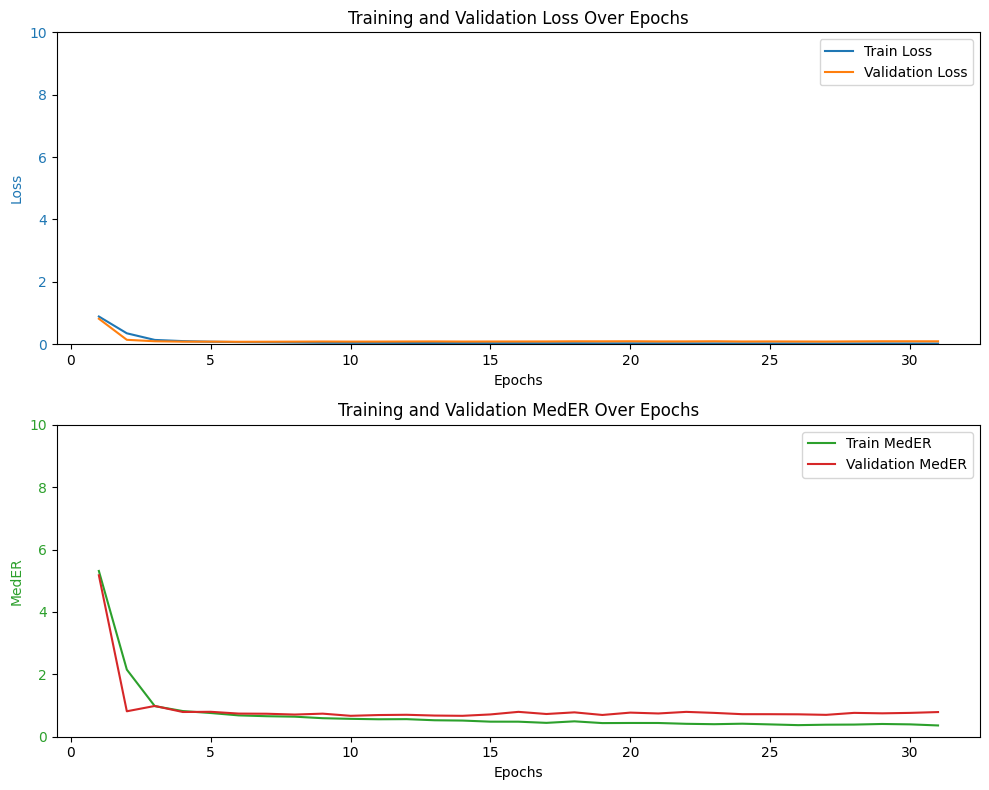

In [44]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Number of epochs and batch size
num_epochs = 300
batch_size = 32

train_losses = []
val_losses = []
train_mer = []
val_mer = []

# Early stopping parameters
patience = 25
best_val_loss = float('inf')
epochs_without_improvement = 0

# Training loop
for epoch in range(num_epochs):
    # Train phase
    model.train()  # Set the model to training mode
    running_train_loss = 0.0
    running_train_mer = 0.0

    for i in range(0, len(X_train), batch_size):
        # Create mini-batches for training
        X_batch = X_train[i:i + batch_size]
        y_batch_ratings = y_train_ratings[i:i + batch_size]

        optimizer.zero_grad()
        # Forward pass
        rating_pred = model(X_batch)

        # Calculate the loss
        loss_rating = criterion(rating_pred, y_batch_ratings.view(-1, 1))

        # Backward pass (compute gradients)
        loss_rating.backward()

        # Update model parameters using the optimizer
        optimizer.step()

        # Track the training loss
        running_train_loss += loss_rating.item()

        # Calculate the Median Error Rate (MedER) for the current batch
        abs_error = torch.abs(rating_pred.view(-1) - y_batch_ratings)
        med_er = torch.median(abs_error)
        running_train_mer += med_er.item()

    # Calculate the average training loss and MedER for the epoch
    avg_train_loss = running_train_loss / len(X_train)
    avg_train_mer = running_train_mer / (len(X_train) / batch_size)

    # Store values for plotting
    train_losses.append(avg_train_loss)
    train_mer.append(avg_train_mer)

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    running_val_mer = 0.0

    with torch.no_grad():  # No gradients for validation
        for i in range(0, len(X_val), batch_size):
            # Create mini-batches for validation
            X_batch_val = X_val[i:i + batch_size]
            y_batch_ratings_val = y_val_ratings[i:i + batch_size]

            # Forward pass for validation
            rating_pred_val = model(X_batch_val)

            # Calculate the loss for validation
            loss_rating_val = criterion(rating_pred_val, y_batch_ratings_val.view(-1, 1))

            # Track the validation loss
            running_val_loss += loss_rating_val.item()

            # Calculate the Median Error Rate (MedER) for the validation batch
            abs_error_val = torch.abs(rating_pred_val.view(-1) - y_batch_ratings_val)
            med_er_val = torch.median(abs_error_val)
            running_val_mer += med_er_val.item()

    # Calculate the average validation loss and MedER
    avg_val_loss = running_val_loss / len(X_val)
    avg_val_mer = running_val_mer / (len(X_val) / batch_size)

    # Store values for plotting
    val_losses.append(avg_val_loss)
    val_mer.append(avg_val_mer)

    # Print the results for the current epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train MedER: {avg_train_mer:.4f}, "
          f"Validation Loss: {avg_val_loss:.4f}, Validation MedER: {avg_val_mer:.4f}")

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping on epoch {epoch + 1}")
        break

# Create a figure with two subplots for separate graphs
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot the train and validation loss
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='tab:blue')
ax1.plot(range(1, len(train_losses) + 1), train_losses, color='tab:blue', label='Train Loss')
ax1.plot(range(1, len(val_losses) + 1), val_losses, color='tab:orange', label='Validation Loss')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='upper right')
ax1.set_title('Training and Validation Loss Over Epochs')
ax1.set_ylim([0, 10])

# Plot the train and validation MedER
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MedER', color='tab:green')
ax2.plot(range(1, len(train_mer) + 1), train_mer, color='tab:green', label='Train MedER')
ax2.plot(range(1, len(val_mer) + 1), val_mer, color='tab:red', label='Validation MedER')
ax2.tick_params(axis='y', labelcolor='tab:green')
ax2.legend(loc='upper right')
ax2.set_title('Training and Validation MedER Over Epochs')
ax2.set_ylim([0, 10])
# Adjust layout and display
fig.tight_layout()
plt.show()


# Evaluate the model on the test data

In [45]:

model.eval()
running_test_loss = 0.0
total_samples = 0

with torch.no_grad():
    for i in range(0, len(X_test), batch_size):

        X_batch = X_test[i:i+batch_size]
        y_batch_ratings = y_test_ratings[i:i+batch_size]

        # Forward pass
        rating_pred = model(X_batch)

        # Calculate the loss (only for IMDb rating)
        loss_rating = criterion(rating_pred, y_batch_ratings.view(-1, 1))

        # Track the test loss
        running_test_loss += loss_rating.item()
        total_samples += X_batch.size(0)

# Print the average test loss
average_test_loss = running_test_loss / total_samples
print(f"Test Loss: {average_test_loss:.4f}")


Test Loss: 0.0889


Predicting the imdb rating of a movie

In [47]:
import torch
import numpy as np


# New movie details
new_movie = {
    'plot': "Two middle-aged men who are struggling to adjust to the digital age manage to land internships at Google, where they have to compete against younger, more tech-savvy candidates.",
    'keywords': "internship, Google, comedy, technology, competition",
    'producers': "Vince Vaughn, Shawn Levy",
    'directors': "Shawn Levy",
    'casting directors': "Sarah Halley Finn",
    'taglines': "In the digital age, being human is the ultimate hack.",
    'genres': "Comedy",
    'year': 2013
}

# Process the new movie features using Word2Vec and other preprocessors
X_new_movie_vecs = np.hstack([
    get_average_word2vec(new_movie['plot'], word2vec_model),
    get_average_word2vec(new_movie['keywords'], word2vec_model),
    get_average_word2vec(new_movie['producers'], word2vec_model),
    get_average_word2vec(new_movie['directors'], word2vec_model),
    get_average_word2vec(new_movie['casting directors'], word2vec_model),
    get_average_word2vec(new_movie['taglines'], word2vec_model)
])

# Process categorical features (genres)
X_new_movie_genres = mlb.transform([new_movie['genres'].split(',')])

# Flatten the binary matrix returned by MultiLabelBinarizer
X_new_movie_genres = X_new_movie_genres.flatten()

# Process numerical features (year)
X_new_movie_year = scaler.transform([[new_movie['year']]])

# Combine all features into one feature vector
X_new_movie_combined = np.hstack([X_new_movie_vecs, X_new_movie_genres, X_new_movie_year.flatten()])

# Convert to PyTorch tensor and add batch dimension
X_new_movie_tensor = torch.tensor(X_new_movie_combined, dtype=torch.float32).unsqueeze(0)

# Make predictions using the trained model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # No need to compute gradients for inference
    rating_pred = model(X_new_movie_tensor)  # Only predicting IMDb rating now

# Display the prediction for IMDb rating
print(f"Predicted IMDb Rating: {rating_pred.item():.2f}")  # Rating should be between 1 and 10

Predicted IMDb Rating: 6.17


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
